# É possível predizer a porcentagem de lucro de um filme baseado em seus metadados?

Este arquivo tem como fito entender como a distribuição dos metadados em um filme influencia no rendimento do mesmo em seus diversos aspectos, focado no **lucro** ocasionado. De responsabilidade do aluno Antônio Neves

# Análise dos dados

## Importações

In [112]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-bright")

In [2]:
credits = pd.read_csv("../data/credits.csv", index_col=[0])
movies = pd.read_csv("../data/movies_metadata.csv", index_col=[0])

## Pré Processamento

In [3]:
# A coluna "adult" possui todos os valores como falso, sendo inútil
movies = movies.drop("adult", axis=1)

In [4]:
movies = movies[~movies.index.duplicated(keep="first")]

In [5]:
# Eliminando filmes duplicados
credits = credits.reset_index().drop("index", axis=1)

In [6]:
credits["movie_id"] = credits["movie_id"].astype(str)
movies.index = movies.index.astype(str)

In [7]:
# Retirando todos os filmes nos quais não possui informações de custo e receita final.
movies = movies.query("revenue >= 1000.0 and budget >= 1000.0")

In [8]:
# Aplicando a mesma transformação no dataset de créditos
credits = credits[credits["movie_id"].isin(movies.index)]

In [9]:
# Retirando todos os filmes que não possui pelo menos um ator no dataset
movies = movies.loc[credits["movie_id"].unique(), :]

In [10]:
movies["profit"] = movies["revenue"] - movies["budget"]
movies["profit_rate"] = movies["profit"] / movies["budget"]

In [11]:
credits["profit"] = credits["movie_id"].apply(lambda row: movies.loc[row, "profit"])
credits["profit_rate"] = credits["movie_id"].apply(lambda row: movies.loc[row, "profit_rate"])

In [12]:
# Não há dados faltantes no dataset de crédito na coluna de identificador único da pessoa
credits["id"].isna().sum()

0

In [13]:
# Adicionando uma coluna nova de número de atores/atrizes por filme
n_actors = credits.groupby("movie_id").count()["id"]

movies = pd.merge(movies, n_actors, left_index=True, right_on="movie_id")
movies = movies.rename(columns={"id": "n_actors"})

In [14]:
profit_by_actors = credits.groupby("id")["profit_rate"].sum()
count_by_actors = credits.groupby("id")["profit_rate"].count()

r_movies = movies.reset_index()

def mean_actors_rate_profit_per_movie(movie):    
    id = movie["movie_id"]
    profit_rate = movie["profit_rate"]

    
    return np.array([
        (profit_by_actors[actor] - profit_rate) / (count_by_actors[actor]-1) 
        if count_by_actors[actor] > 1
        else 0
        for actor in credits.query(f"movie_id == '{id}'")["id"]  
    ]).mean()
        
movies["mean_of_profits_per_actors"] = r_movies.apply(mean_actors_rate_profit_per_movie, axis=1).values

In [15]:
def get_outliers(df, column, threshold=2):
    x = df[column]

    z_score = np.abs((x - x.mean()) / x.std())

    outliers = df[z_score > threshold]

    return outliers

Com a possibilidade de analisar os outliers do modelo, verificamos quais são maiores que determinado **z-value**.

In [16]:
get_outliers(movies, "profit_rate", threshold=2)

,budget,genres,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count,profit,profit_rate,n_actors,mean_of_profits_per_actors
movie_id,,,,,,,,,,,,,,,,,
692,12000,Horror - Comedy - Crime,en,Pink Flamingos,5.738871,"[{'iso_3166_1': 'US', 'name': 'United States o...",1972-03-12,6000000,93.0,Released,Pink Flamingos,6.2,111.0,5988000,499.000000,11,-0.056358
2667,60000,Horror - Mystery,en,The Blair Witch Project,14.838386,"[{'iso_3166_1': 'US', 'name': 'United States o...",1999-07-14,248000000,81.0,Released,The Blair Witch Project,6.3,1090.0,247940000,4132.333333,10,0.222707
985,10000,Drama - Fantasy - Horror - Science Fiction,en,Eraserhead,7.871001,"[{'iso_3166_1': 'US', 'name': 'United States o...",1977-03-19,7000000,89.0,Released,Eraserhead,7.5,500.0,6990000,699.000000,11,1.319663
9462,130000,Action - Crime,cn,猛龍過江,11.116474,"[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",1972-06-01,85000000,100.0,Released,The Way of the Dragon,7.4,235.0,84870000,652.846154,15,14.376912
9372,65000,Documentary - Comedy - Drama,en,Super Size Me,5.266103,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-17,28575078,100.0,Released,Super Size Me,6.6,520.0,28510078,438.616585,15,0.000000
83,130000,Drama - Thriller,en,Open Water,10.652818,"[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,54667954,79.0,Released,Open Water,5.3,320.0,54537954,419.522723,6,0.950589
23827,15000,Horror - Mystery,en,Paranormal Activity,12.706424,"[{'iso_3166_1': 'US', 'name': 'United States o...",2007-09-14,193355800,86.0,Released,Paranormal Activity,5.9,1351.0,193340800,12889.386667,5,18.741511
299245,100000,Horror - Thriller,en,The Gallows,7.51505,"[{'iso_3166_1': 'US', 'name': 'United States o...",2015-07-10,42664410,87.0,Released,The Gallows,4.9,370.0,42564410,425.644100,11,0.068390
363093,5000,Action - Adventure - History - Thriller,ko,대호,3.447894,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2015-12-16,11083449,139.0,Released,The Tiger: An Old Hunter's Tale,7.5,17.0,11078449,2215.689800,6,0.942388


In [17]:
get_outliers(movies, "profit_rate", threshold=0.5)

,budget,genres,original_language,original_title,popularity,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count,profit,profit_rate,n_actors,mean_of_profits_per_actors
movie_id,,,,,,,,,,,,,,,,,
2292,27000,Comedy,en,Clerks,10.513367,"[{'iso_3166_1': 'US', 'name': 'United States o...",1994-09-13,3151130,92.0,Released,Clerks,7.4,769.0,3124130,115.708519,15,2.392496
408,1488423,Fantasy - Animation - Family,en,Snow White and the Seven Dwarfs,16.263878,"[{'iso_3166_1': 'US', 'name': 'United States o...",1937-12-20,184925486,83.0,Released,Snow White and the Seven Dwarfs,6.9,1973.0,183437063,123.242561,13,29.450849
10331,114000,Horror,en,Night of the Living Dead,14.384198,"[{'iso_3166_1': 'US', 'name': 'United States o...",1968-10-01,30000000,96.0,Released,Night of the Living Dead,7.5,591.0,29886000,262.157895,13,3.789525
12092,3000000,Animation - Adventure - Family - Fantasy,en,Alice in Wonderland,16.488937,"[{'iso_3166_1': 'US', 'name': 'United States o...",1951-07-03,572000000,75.0,Released,Alice in Wonderland,7.0,1557.0,569000000,189.666667,15,24.825879
1366,1000000,Drama,en,Rocky,14.774066,"[{'iso_3166_1': 'US', 'name': 'United States o...",1976-11-21,117235147,119.0,Released,Rocky,7.5,1843.0,116235147,116.235147,37,6.232454
4488,550000,Horror,en,Friday the 13th,12.146747,"[{'iso_3166_1': 'US', 'name': 'United States o...",1980-05-09,59754601,95.0,Released,Friday the 13th,6.4,622.0,59204601,107.644729,23,2.865257
948,300000,Horror - Thriller,en,Halloween,13.672759,"[{'iso_3166_1': 'US', 'name': 'United States o...",1978-10-25,70000000,91.0,Released,Halloween,7.4,1066.0,69700000,232.333333,25,2.629287
3170,858000,Animation - Drama - Family,en,Bambi,13.698132,"[{'iso_3166_1': 'US', 'name': 'United States o...",1942-08-14,267447150,70.0,Released,Bambi,6.8,1450.0,266589150,310.709965,11,28.180456
692,12000,Horror - Comedy - Crime,en,Pink Flamingos,5.738871,"[{'iso_3166_1': 'US', 'name': 'United States o...",1972-03-12,6000000,93.0,Released,Pink Flamingos,6.2,111.0,5988000,499.000000,11,-0.056358


## Análise do Lucro

**Boxplot da taxa de lucro dos filmes, entendendo sua distribuição**

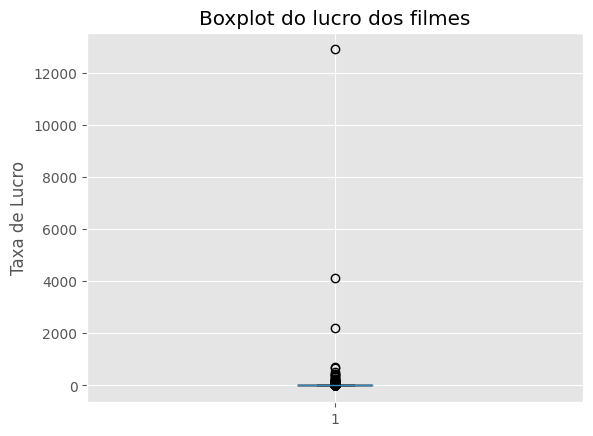

In [18]:
plt.boxplot(movies["profit_rate"])
plt.title("Boxplot do lucro dos filmes")
plt.ylabel("Taxa de Lucro")
plt.show()

Há uma concentração bem grande perto de zero e um acerca de taxa de lucro. Nota-se também que os outliers são dominantes no plot.

**Relação entre a quantidade de atores do filme e o lucro obtido**

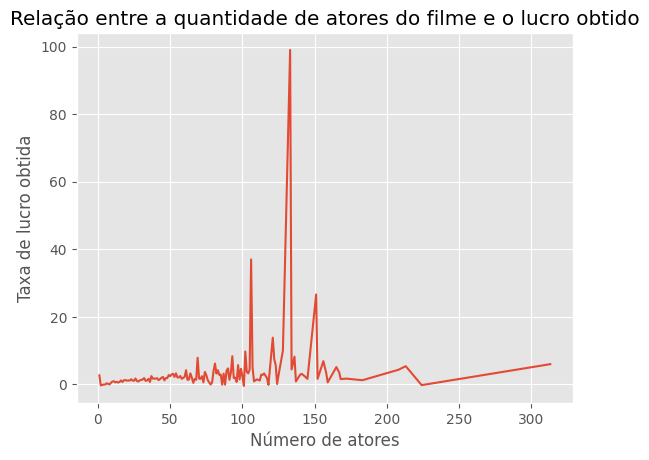

In [19]:
movies.groupby("n_actors")["profit_rate"].median().plot()
plt.xlabel("Número de atores")
plt.ylabel("Taxa de lucro obtida")
plt.title("Relação entre a quantidade de atores do filme e o lucro obtido")
plt.show()

A quantidade de atores/atrizes em um filme não aparenta ter correlação visual com a taxa de lucro

**Quantidade de filmes feitos por países**

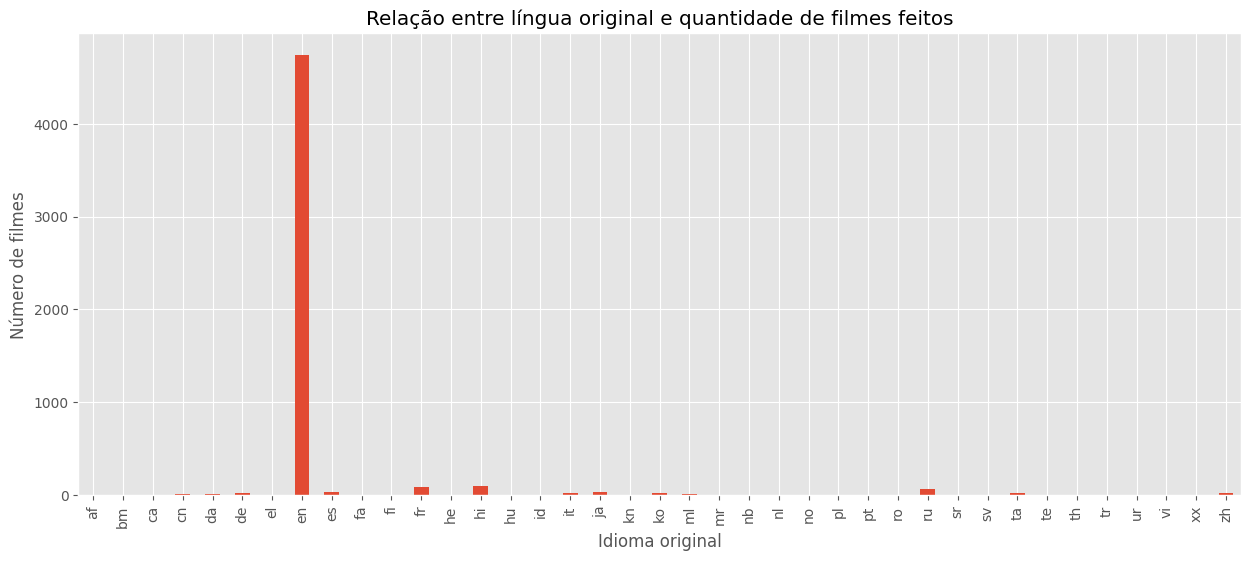

In [20]:
plt.figure(figsize=(15, 6))
movies.groupby("original_language")["profit_rate"].count().plot(kind="bar")
plt.title("Relação entre língua original e quantidade de filmes feitos")
plt.xlabel("Idioma original")
plt.ylabel("Número de filmes")
plt.show()

Há uma grande concentração de filmes de língua inglesa.

**O filme ser de determinado local, tem impacto no lucro?**

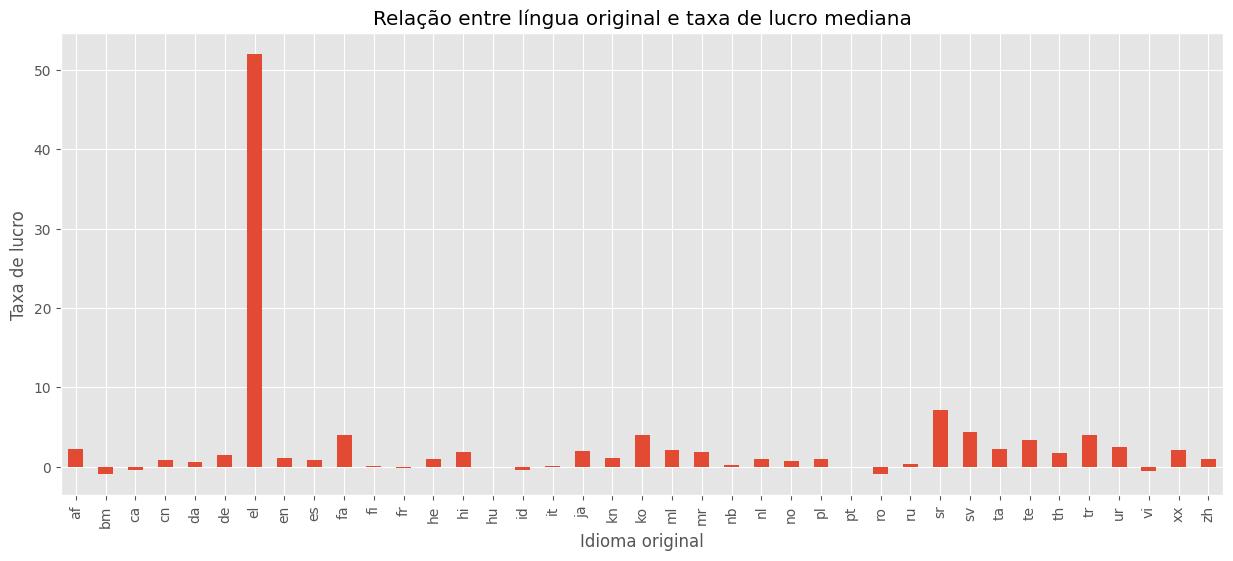

In [21]:
plt.figure(figsize=(15, 6))
movies.groupby("original_language")["profit_rate"].median().plot(kind="bar")
plt.title("Relação entre língua original e taxa de lucro mediana")
plt.xlabel("Idioma original")
plt.ylabel("Taxa de lucro")
plt.show()

O idioma não deve significar profundamente algo acerca do lucro, pois como a maioria dos filmes são de idiona nativo língua inglesa, os outros não possuem quantidade o suficiente para supor uma correlação.

**Tempo de filme vs Lucro**

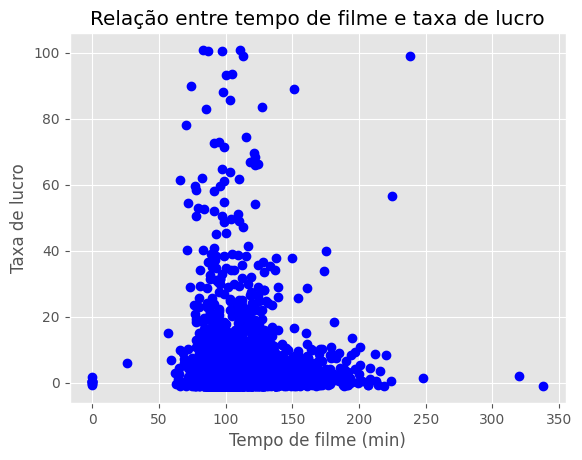

In [22]:
without_outliers = movies.drop(get_outliers(movies, "profit_rate", threshold=0.5).index)
plt.plot(without_outliers["runtime"].values, without_outliers["profit_rate"].values, "bo")
plt.title("Relação entre tempo de filme e taxa de lucro")
plt.xlabel("Tempo de filme (min)")
plt.ylabel("Taxa de lucro")
plt.show()

**Média de taxa de lucro dos atores do filme vs próprio filme**

Visualização do gráfico é confusa, pois o valor de comparação não leva em consideração a remoção de outliers, mas o dado de entrada sim

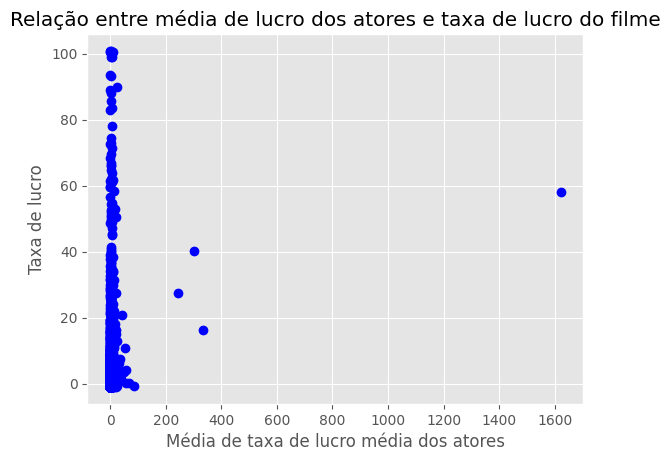

In [23]:
without_outliers = movies.drop(get_outliers(movies, "profit_rate", threshold=0.5).index)
plt.plot(without_outliers["mean_of_profits_per_actors"].values, without_outliers["profit_rate"].values, "bo")
plt.title("Relação entre média de lucro dos atores e taxa de lucro do filme")
plt.xlabel("Média de taxa de lucro média dos atores")
plt.ylabel("Taxa de lucro")
plt.show()

## Teste de Hipótese

Durante a análise, vimos que o tempo de duração do filme pode ser um fator impactante, mesmo controvérsio, pois em tese o número de filmes com 100 minutos de duração são os maiores. Com isso, podemos elaborar a nossa hipótese nula e a alternativa

$H_0 =$ **tempo de filme não possui relação com lucro** <br />
    $H_1 =$ **existe uma provável relação**

Iremos assumir um nível de significância de **5%**

In [24]:
import scipy.stats as ss

without_na = movies.dropna(subset=["runtime"])

rate_profit = without_na["profit_rate"].values
runtime = without_na["runtime"].values

ss.spearmanr(rate_profit, runtime)

SignificanceResult(statistic=0.06358195247549236, pvalue=3.6446257279166434e-06)

In [25]:
unique_values, counts = np.unique(movies["runtime"].values, return_counts=True)
index_of_max_count = np.argmax(counts)
unique_values[index_of_max_count], counts[index_of_max_count]

(100.0, 163)

Nota-se que o índice de correlação, que é entre -1 e 1, está bem longe dos extremos, indicando quase nula a correlação, aceitando a hipótese nula, mas o p-value é baixo e menor que o nível de significância, o que significa que a distribuição não pode ser explicada ao acaso. E, como foi previsto, a moda da duração dos filmes é 100 minutos, valor que no gráfico é notável que há uma maior quantidade de filmes com taxa de lucro.

Agora será feito o mesmo teste, mas para os dados de popularidade.

$H_0 =$ **popularidade de filme não possui relação com lucro** <br />
    $H_1 =$ **existe uma provável relação**

Iremos assumir um nível de significância de **5%**

In [26]:
rate_profit = without_na["profit_rate"].values
popularity = without_na["popularity"].values

ss.spearmanr(rate_profit, popularity)

SignificanceResult(statistic=-0.03160971700799668, pvalue=0.0214263965206702)

Os mesmos resultados vistos no último teste se equivalem aqui.

Agora será feito o mesmo teste, mas para os dados de média da média de taxa de lucro dos atores dos filmes.

$H_0 =$ **os atores presentes possuem no filme não influenciam no lucro** <br />
    $H_1 =$ **existe uma provável relação**

Iremos assumir um nível de significância de **5%**

In [27]:
rate_profit = without_na["profit_rate"].values
mean_of_profits_per_actors = without_na["mean_of_profits_per_actors"].values

ss.spearmanr(rate_profit, mean_of_profits_per_actors)

SignificanceResult(statistic=0.17168431686297494, pvalue=2.5635754004269416e-36)

Subsequentemente, foi notado uma correlação maior, mas não significante, e um p-value menor que o nível de significância.

# Regressão + Classificação

## Pré Processamento para ML

In [166]:
features = ["budget", "runtime", "vote_average", "popularity", "vote_count", "n_actors", "mean_of_profits_per_actors"]

movies = movies.dropna()

X = np.asarray(movies[features]).astype(np.float32)
y = np.asarray(movies["profit_rate"]).astype(np.float32)

In [167]:
from sklearn.preprocessing import StandardScaler

# Caso aplicasse a z-normalização no y, mas testes foram realizados e viu que o erro absoluto médio era maior
y_mean = y.mean()
y_std = y.std()

X = StandardScaler().fit_transform(X)

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, test_size=0.2)

### Regressão Linear

In [169]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [170]:
model = LinearRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [171]:
mae = mean_absolute_error(predicted, y_test)

print(f"MAE: {mae}")

MAE: 11.86780071258545


### MLP

Para testar outro modelo além da regressão linear, foi realizado uma rede neural de múltiplas camadas para realizar a tarefa de regressão. Possui 5 camadas, sendo 4 com função de ativação "relu" e uma de Dropout para fitos de regularização.

In [172]:
import tensorflow as tf
from tensorflow import keras

In [184]:
regression_model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

regression_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                256       
                                                                 
 dense_29 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [191]:
regression_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

In [192]:
regression_model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
67/67 [==============================] - 1s 2ms/step - loss: 8.4620 - mae: 8.4620
Epoch 2/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4525 - mae: 8.4525
Epoch 3/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4543 - mae: 8.4543
Epoch 4/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4463 - mae: 8.4463
Epoch 5/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4382 - mae: 8.4382
Epoch 6/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4413 - mae: 8.4413
Epoch 7/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4392 - mae: 8.4392
Epoch 8/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4511 - mae: 8.4511
Epoch 9/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4233 - mae: 8.4233
Epoch 10/20
67/67 [==============================] - 0s 2ms/step - loss: 8.4397 - mae: 8.4397
Epoch 11/20
67/67 [==============================] - 0s 2ms/step - lo

In [193]:
predicted = regression_model.predict(X_test)

34/34 [==============================] - 0s 974us/step


In [194]:
mean_absolute_error(predicted, y_test)

4.7864966

Conseguimos um erro absoluto médio por volta de 5 no mínimo em MLP, ao contrário de por volta 11.86 em Regressão Linear.

Independente, 5 é um MAE bem alto para nossa tarefa, pois não é uma forma muito confiável de predizer taxa de lucro ao dizer que seu filme pode retornar entre -4 e 6 de taxa de lucro, supondo 1 como central.

## Classificação

Devido a tarefa de regressão não ser satisfatória em resultados de predição, agora queremos saber se o filme deu lucro ou não, ou seja, se a taxa foi maior que um ou menor que um

In [148]:
import scipy.stats as st

from scipy.stats import norm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

In [149]:
y = np.asarray((movies["profit_rate"] > 1).astype(int))

Como forma de controle, assumimos que o modelo é burro, ou seja, dado a probabilidade de dar lucro igual a frequência de filmes que dão lucro, observamos como nossa distribuição de Bernoulli, com uma variação do acaso, consegue explicar o intervalo dado, com 99,99% de confiança.

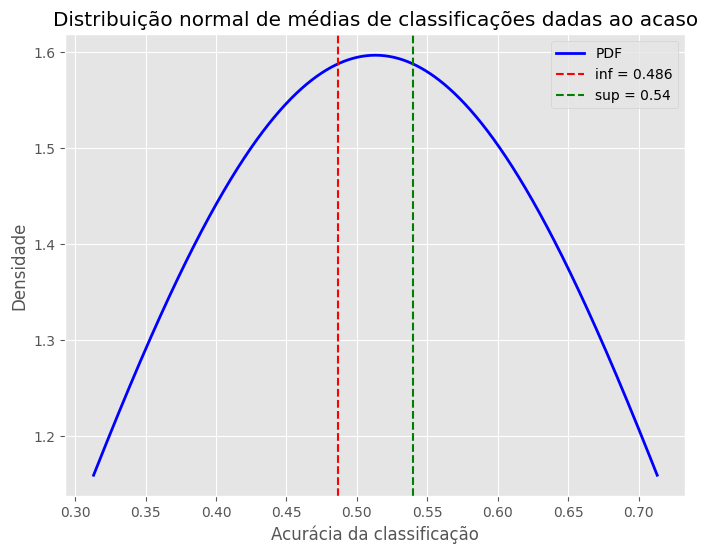

In [150]:
p = y.mean()
st.sem(y)

inf, sup = st.t.interval(confidence=0.9999, df=len(y)-1,
    loc=p,
    scale=st.sem(y)
)

x = np.linspace(p-0.2, p+0.2, 1000)

pdf = norm.pdf(x, p, p*(1-p))

plt.figure(figsize=(8, 6))
plt.plot(x, pdf, color='blue', linewidth=2, label='PDF')
plt.title("Distribuição normal de médias de classificações dadas ao acaso")
plt.xlabel("Acurácia da classificação")
plt.ylabel("Densidade")

plt.axvline(x=inf, color='r', linestyle='--', label=f"inf = {round(inf, 3)}")
plt.axvline(x=sup, color='g', linestyle='--', label=f"sup = {round(sup, 3)}")

plt.legend()
plt.show()

### Random Forest

O primeiro teste é com Random Forest, onde com 10 estimadores foi realizado uma *cross validation* com 10 separações, e após calculado o intervalo de confiança da ambas as métricas utilizadas.

In [151]:
forest = RandomForestClassifier(n_estimators=10, random_state=15)

In [152]:
scores_macro = cross_val_score(forest, X, y, cv=10, scoring='f1_macro',n_jobs=-1)
scores_accuracy = cross_val_score(forest, X, y, cv=10, scoring='accuracy')

interval_macro=st.t.interval(confidence=0.95, df=len(scores_macro)-1,
      loc=np.mean(scores_macro),
      scale=st.sem(scores_macro)
)

interval_accuracy=st.t.interval(confidence=0.95, df=len(scores_accuracy)-1,
      loc=np.mean(scores_accuracy),
      scale=st.sem(scores_accuracy)
)

In [153]:
pd.DataFrame(data=[
        [round(np.mean(scores_macro), 4), round(np.mean(scores_macro) - interval_macro[0], 5)],
        [round(np.mean(scores_accuracy), 4), round(np.mean(scores_accuracy) - interval_accuracy[0], 5)],
    ], columns=["Média", "Intervalo de Confiança"], index=["F1 Macro", "Acurácia"])

,Média,Intervalo de Confiança
F1 Macro,0.6973,0.01775
Acurácia,0.6991,0.01745


Nossa acurácia supera uma previsão *dummy* de lucro, ficando bastante fora do intervalo de confiança. 

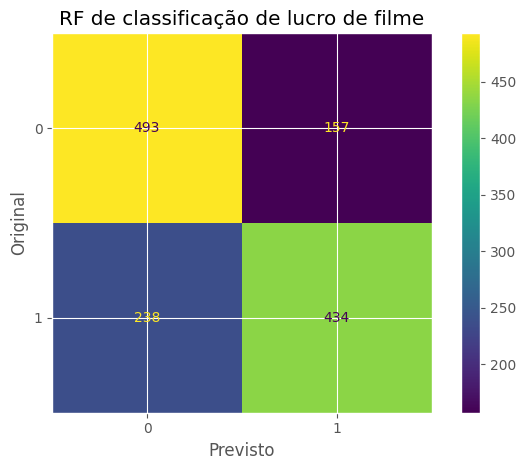

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.ylabel("Original")
plt.xlabel("Previsto")
plt.title("RF de classificação de lucro de filme")
plt.tight_layout()
plt.show()

### MLP

Da mesma forma que na tarefa de regressão, na de classificação iremos utilizar o mesmo modelo de rede neural, com a última camada sendo a função de ativação *sigmoid* para retornar entre 0 e 1, no caso, a probabilidade do filme dar lucro.

In [155]:
classification_model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

classification_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                256       
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4481 (17.50 KB)
Trainable params: 4481 (17.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [159]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

classification_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.7228 - val_loss: 0.4858 - val_accuracy: 0.7492
Epoch 2/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.7266 - val_loss: 0.5047 - val_accuracy: 0.7432
Epoch 3/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.7289 - val_loss: 0.4983 - val_accuracy: 0.7251
Epoch 4/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.7195 - val_loss: 0.4966 - val_accuracy: 0.7341
Epoch 5/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5353 - accuracy: 0.7221 - val_loss: 0.5066 - val_accuracy: 0.7341
Epoch 6/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5335 - accuracy: 0.7296 - val_loss: 0.4939 - val_accuracy: 0.7492
Epoch 7/10
124/124 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.7286 - val_loss: 0.4863 - val_accuracy: 0.7462
Epoch 

In [163]:
predicted = classification_model.predict(X_test)

threshold = 0.5

result = (predicted > threshold).astype(int)

print(f"F1: {f1_score(result, y_test)}")
print(f"Acurácia: {accuracy_score(result, y_test)}")

11/11 [==============================] - 0s 1ms/step
F1: 0.7003154574132492
Acurácia: 0.7121212121212122


Além de superar uma previsão *dummy* de lucro, teve um certo aumento de acurácia e F1 macro sobre o RF. 

# Conclusões

Relembrando nossa pergunta:

**É possível predizer a porcentagem de lucro de um filme baseado em seus metadados?**

Na análise dos dados, foi notado uma quantidade grande de outliers presente nos dados, o que condiz com o que o mercado de cinema possui, pois a maioria dos filmes tendem a manter uma média de lucro perto de 1, mas alguns são disruptivos o suficiente ou para ser um sucesso de bilheteria, ou para ser um total fracasso. Dito isso, predizer tais outliers é importante e por isso não foi excluído na análise.

Subsequentemente, de forma visual em gráficos, foi plotado possíveis relações entre *features* e a variável-alvo: taxa de lucro, além de outros plots para maior entendimento da distribuição das features. Visualmente, não foi encontrado nenhuma correlação forte, concluindo que o dataset é bem esparso em seu espaço amostral.

Nos testes de hipóteses, queríamos ver se possíveis features possuem correlação alta com a nossa variável. Para tal, foi utilizado a Correlação de Spearman, onde a partir da utilização do posto de ordenação entre as variáveis, calcula a correlação normal. Além disso, a função retorna o *p-value*, ou seja, qual a chance daquela correlação ser explicada ao acaso. Todas trouxeram baixas correlações, aceitando a hipótese nula, e um *p-value* bem baixo.

Na regressão, a partir de selecionar features que foram analisadas do dataset como dados de entrada do modelo, foi testado Regressão Linear e uma simples MLP. Ambas não retornaram um resultado satisfatório, o que fez o grupo concluir que não é possível predizer numericamente a porcentagem de lucro de um filme.

Já na classificação, verificamos nosso grupo controle: um modelo que obedece a frequência em que os filmes dão lucro, que é próximo a 50%. Queremos que nossos modelos de classificação sejam melhor que o *dummy model*, e foram, com taxas que chegaram a 70% de acurácia e Macro F1

*Portanto, predizer numericamente os dados não é possível, devido ao mercado do cinema ser bem variável nos dados, mas predizer em classificação, com um problema de decisão: o filme vai dar lucro ou não, é promissor, devido a encontrar taxas de acerto bem maior que o acaso.*